# 03 SVI Part I: Introduction to SVI

$$ p_\theta (\bold{x}, \bold{z}) = p_\theta (\bold{x} | \bold{z}) p_\theta(\bold{z}) $$

$$ \log p_\theta (\bold{x}) = \log \int p_\theta(\bold{x}, \bold{z}) d\bold{z} $$

The guide introduces $ q_\phi(\bold{z}) $ that serves as approximation of the posterior

$$ \text{ELBO} \equiv \mathbb{E}_{q_{\phi} (\bold{z})} [\log p_\theta(\bold{x}, \bold{z}) - \log q_\phi (\bold{z})] $$

$$ \log p_\theta (\bold{x}) \geq \text{ELBO} $$

$$ \log p_\theta (\bold{x}) - \text{ELBO} = \text{KL}(q_\phi(\bold{z}) || p_\theta(\bold{z} | \bold{x})) $$

In [3]:
import pyro
from pyro.infer import SVI, Trace_ELBO
def model(): pass 
def guide(): pass
optimizer = pyro.optim.Adam({})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [4]:
from pyro.optim import Adam

def per_param_callable(param_name):
    if param_name == 'my_special_parameter':
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)

## Example

In [8]:
import math
import os
import torch
import torch.distributions.constraints as C
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as D

In [36]:
data = torch.randint(0, 2, (10, )).type(torch.float)
data

tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 0.])

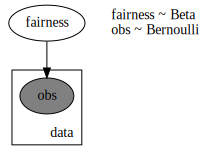

In [37]:
def model(data=None):
    alpha0 = torch.tensor(10.)
    beta0 = torch.tensor(10.)
    f = pyro.sample('fairness', D.Beta(alpha0, beta0))
    
    with pyro.plate('data', len(data)):
        return pyro.sample('obs', D.Bernoulli(f), obs=data)
        
pyro.render_model(model, model_args=(data, ), render_distributions=True)

In [38]:
def guide(data):
    alpha = pyro.param('alpha', torch.tensor(15.),
                       constraint=C.positive)
    beta = pyro.param('beta', torch.tensor(15.),
                      constraint=C.positive)
    pyro.sample('fairness', D.Beta(alpha, beta))

In [39]:
from tqdm import trange

In [40]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
for step in trange(n_steps):
    svi.step(data)

100%|██████████| 5000/5000 [00:19<00:00, 257.96it/s]


In [41]:
alpha = pyro.param('alpha').item()
beta = pyro.param('beta').item()

mean = alpha / (alpha + beta)
factor = beta / (alpha * (1. + alpha + beta))
std = mean * math.sqrt(factor)

print(f'Fairness: {mean:.3f} +- {std:.3f}')

Fairness: 0.464 +- 0.089
